In [217]:
#All import statements here
import sys
import os
import pickle
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

import nltk
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import map_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('always')

# Load NLTK's English stop-words list
stop_words = set(stopwords.words('english'))

print("Loading already processed training data")
data_df = pd.read_excel("/Users/pragya/Desktop/Grad SemB/Not All bugs are the same/dataset+additional_analysis.xlsx", sheet_name="Dataset - Bug Report")                       #/Users/pragya/Desktop/Not All bugs are the same/dataset.csv
data_df.head(5)   
data_df['Classification'].unique()

Loading already processed training data


array(['Add issue', 'Configuration issue', 'Database-related issue',
       'Functional issue', 'GUI-related issue', 'info release issue',
       'Network issue', 'Performance issue',
       'Permission/Deprecation issue', 'Security issue',
       'Test Code-related issue'], dtype=object)

In [218]:
data_df["Classification"] = data_df["Classification"].apply(
    lambda x: [x]
)
print(data_df["Classification"].values[:5])

#Splitting data using Stratified splitting function
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    data_df,
    test_size=test_split,
    stratify=data_df["Classification"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")


[list(['Add issue']) list(['Add issue']) list(['Add issue'])
 list(['Add issue']) list(['Add issue'])]
Number of rows in training set: 1152
Number of rows in validation set: 64
Number of rows in test set: 64


In [137]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

import matplotlib.pyplot as plt

arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
print(arxiv_data.head())

# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

                                              titles  \
0  Survey on Semantic Stereo Matching / Semantic ...   
1  FUTURE-AI: Guiding Principles and Consensus Re...   
2  Enforcing Mutual Consistency of Hard Regions f...   
3  Parameter Decoupling Strategy for Semi-supervi...   
4  Background-Foreground Segmentation for Interio...   

                                           summaries  \
0  Stereo matching is one of the widely used tech...   
1  The recent advancements in artificial intellig...   
2  In this paper, we proposed a novel mutual cons...   
3  Consistency training has proven to be an advan...   
4  To ensure safety in automated driving, the cor...   

                         terms  
0           ['cs.CV', 'cs.LG']  
1  ['cs.CV', 'cs.AI', 'cs.LG']  
2           ['cs.CV', 'cs.AI']  
3                    ['cs.CV']  
4           ['cs.CV', 'cs.LG']  


array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

In [138]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 44986
Number of rows in validation set: 2500
Number of rows in test set: 2499


In [139]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'cs.SI', 'math.OC', 'eess.SP', 'cs.GR', 'cs.MM', 'cs.IR', 'cs.SY', 'cs.MA', 'cs.HC', 'eess.SY', 'stat.AP', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'q-bio.QM', 'eess.AS', 'stat.ME', 'stat.TH', 'math.ST', 'cs.SD', 'q-bio.NC', 'cs.DS', 'math.NA', 'cs.CG', 'I.2.6', 'physics.chem-ph', 'cs.NA', 'cs.SE', 'cs.NI', 'cs.GT', 'stat.CO', 'q-bio.BM', '68T45', 'cs.DB', 'physics.comp-ph', 'cs.LO', 'math.PR', 'cond-mat.dis-nn', 'cs.CE', 'cs.PL', 'physics.data-an', 'q-fin.ST', 'cond-mat.stat-mech', 'I.2.10', 'cs.AR', 'I.4.6', '68T05', 'math.DS', 'cs.DM', 'quant-ph', 'cs.PF', 'I.2', '68T07', 'q-bio.GN', 'physics.med-ph', 'physics.geo-ph', 'q-fin.TR', 'physics.soc-ph', 'cond-mat.mtrl-sci', 'math.AT', 'q-bio.TO', 'econ.EM', 'cs.CC', 'I.5.4', 'I.4', 'physics.optics', 'physics.ao-ph', 'astro-ph.IM', '68T01', 'q-fin.CP', 'q-bio.MN', '68U10', 'I.4.8', 'hep-ex', 'cs.SC', '68T10', '62H30', 'q-fin.PM', 'math

In [140]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'stat.ML']
Label-binarized representation: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [141]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()


count    44986.000000
mean       157.874405
std         41.399555
min          5.000000
25%        129.000000
50%        156.000000
75%        184.000000
max        462.000000
Name: summaries, dtype: float64

In [142]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    print(labels)
    print(label_binarized)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [143]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

<tf.RaggedTensor [[b'cs.LG', b'stat.ML'], [b'stat.ML', b'cs.AI', b'cs.CV', b'cs.LG'],
 [b'cs.CV'], ..., [b'stat.ML', b'cs.LG'], [b'cs.CV'],
 [b'stat.ML', b'cs.LG']]>
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
<tf.RaggedTensor [[b'cs.CV'], [b'cs.CV', b'cs.AI'], [b'cs.CV'], ..., [b'cs.CV'], [b'cs.CV'],
 [b'cs.LG', b'cs.MA', b'stat.ML']]>
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
<tf.RaggedTensor [[b'cs.CV', b'cs.LG', b'cs.MM'], [b'stat.ML', b'cs.LG', b'stat.ME'],
 [b'cs.CV'], ..., [b'cs.LG', b'cs.AI', b'stat.ML', b'I.2.6'],
 [b'cs.LG', b'cs.AI', b'stat.ML'], [b'cs.CV']]>
[[0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [95]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Many institutions within the healthcare ecosystem are making significant\ninvestments in AI technologies to optimize their business operations at lower\ncost with improved patient outcomes. Despite the hype with AI, the full\nrealization of this potential is seriously hindered by several systemic\nproblems, including data privacy, security, bias, fairness, and explainability.\nIn this paper, we propose a novel canonical architecture for the development of\nAI models in healthcare that addresses these challenges. This system enables\nthe creation and management of AI predictive models throughout all the phases\nof their life cycle, including data ingestion, model building, and model\npromotion in production environments. This paper describes this architecture in\ndetail, along with a qualitative evaluation of our experience of using it on\nreal world problems.'
Label(s): ['cs.LG' 'cs.AI' 'cs.CY']
 
Abstract: b'With the prevalence of accessible depth sensors, dynamic human bo

In [96]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

157954


In [97]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [98]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/3
352/352 [==============================] - 186s 524ms/step - loss: 0.0176 - binary_accuracy: 0.9935 - val_loss: 0.0048 - val_binary_accuracy: 0.9986
Epoch 2/3
352/352 [==============================] - 177s 502ms/step - loss: 0.0011 - binary_accuracy: 0.9997 - val_loss: 0.0058 - val_binary_accuracy: 0.9987
Epoch 3/3
352/352 [==============================] - 176s 499ms/step - loss: 2.3770e-04 - binary_accuracy: 1.0000 - val_loss: 0.0069 - val_binary_accuracy: 0.9987


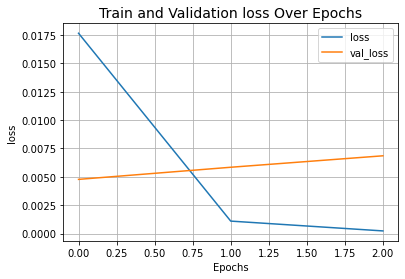

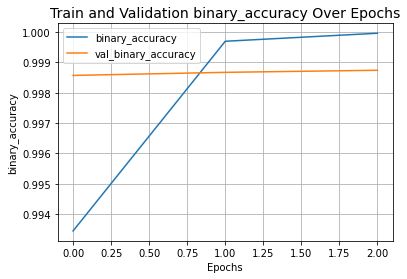

In [100]:
epochs = 3

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [101]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

20/20 [==============================] - 4s 184ms/step - loss: 0.0074 - binary_accuracy: 0.9987
Categorical accuracy on the test set: 99.87%.


In [265]:
terms = tf.ragged.constant(train_df["Classification"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Functional issue', 'GUI-related issue', 'Configuration issue', 'Add issue', 'Test Code-related issue', 'Security issue', 'Network issue', 'Performance issue', 'Permission/Deprecation issue', 'Database-related issue', 'info release issue']


In [266]:
sample_label = train_df["Classification"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Functional issue']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [267]:
train_df["Summary"].apply(lambda x: len(x.split(" "))).describe()

count    1152.000000
mean        8.144965
std         3.642923
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        27.000000
Name: Summary, dtype: float64

In [268]:
max_seqlen = 8
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Classification"].values)
    print(labels.shape)
    label_binarized = lookup(labels).numpy()
    print(label_binarized.shape)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Summary"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [269]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

(1152, None)
(1152, 12)
(64, None)
(64, 12)
(64, None)
(64, 12)


In [270]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'crash on startup with IBM JRE'
Label(s): ['Functional issue']
 
Abstract: b'[hotbug] JEE5 Web model does not update on changes in web.xml'
Label(s): ['Configuration issue']
 
Abstract: b'Default JLabel text Incorrect'
Label(s): ['Functional issue']
 
Abstract: b'SimpleAttributeDecoder; need parse tree for non-new type args too'
Label(s): ['Functional issue']
 
Abstract: b'Browser is crashing while loading big images( > 5MB)'
Label(s): ['Functional issue']
 


In [271]:
vocabulary = set()
train_df["Summary"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

3375


In [272]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [275]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/9
9/9 [==============================] - 0s 21ms/step - loss: 0.3974 - accuracy: 0.3446 - val_loss: 0.3416 - val_accuracy: 0.3125
Epoch 2/9
9/9 [==============================] - 0s 15ms/step - loss: 0.2184 - accuracy: 0.5590 - val_loss: 0.3128 - val_accuracy: 0.3594
Epoch 3/9
9/9 [==============================] - 0s 15ms/step - loss: 0.1493 - accuracy: 0.7543 - val_loss: 0.2620 - val_accuracy: 0.3906
Epoch 4/9
9/9 [==============================] - 0s 16ms/step - loss: 0.0941 - accuracy: 0.8776 - val_loss: 0.2375 - val_accuracy: 0.5000
Epoch 5/9
9/9 [==============================] - 0s 15ms/step - loss: 0.0556 - accuracy: 0.9384 - val_loss: 0.2490 - val_accuracy: 0.4531
Epoch 6/9
9/9 [==============================] - 0s 16ms/step - loss: 0.0328 - accuracy: 0.9757 - val_loss: 0.2574 - val_accuracy: 0.4688
Epoch 7/9
9/9 [==============================] - 0s 15ms/step - loss: 0.0199 - accuracy: 0.9826 - val_loss: 0.2967 - val_accuracy: 0.4531
Epoch 8/9
9/9 [===================

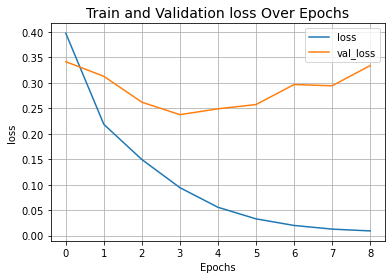

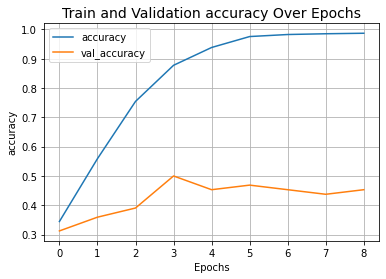

In [282]:
epochs = 9

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
#tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),

# metrics"binary_accuracy"
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
#plot_result("precision_15")
#plot_result("recall_8")
plot_result("accuracy")

In [284]:
_, acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(acc * 100, 2)}%.")

1/1 [==============================] - 0s 74ms/step - loss: 0.2803 - accuracy: 0.5469
Categorical accuracy on the test set: 54.69%.


In [236]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(60), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

predicted_classes=np.argmax(model_for_inference.predict(text_batch),axis=1) 

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(label_batch, predicted_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(label_batch, predicted_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(label_batch, predicted_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(label_batch, predicted_classes)
print('F1 score: %f' % f1)


(60, None)
(60, 12)
2/2 [==============================] - 0s 3ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [230]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(64), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

predicted_classes=np.argmax(model_for_inference.predict(text_batch),axis=1) 

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Summary: {text}")
    print(f"Classification: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Classification: ({', '.join([label for label in top_3_labels])})")
    print(" ")

(64, None)
(64, 12)
2/2 [==============================] - 0s 4ms/step
Summary: b"Agent Controller doesn't shutdown agents"
Classification: ['Add issue']
Predicted Classification: (Functional issue, Configuration issue, GUI-related issue)
 
Summary: b"[PP]Search Messages:open dropdowns don't collapse correctly"
Classification: ['Functional issue']
Predicted Classification: (Functional issue, Configuration issue, GUI-related issue)
 
Summary: b'<IFRAME> tag not supported correctly'
Classification: ['GUI-related issue']
Predicted Classification: (GUI-related issue, Functional issue, Network issue)
 
Summary: b'Release version 1,0'
Classification: ['info release issue']
Predicted Classification: (info release issue, Functional issue, Configuration issue)
 
Summary: b'Crash on console startup in ap_recent_ctime'
Classification: ['Functional issue']
Predicted Classification: (Functional issue, Configuration issue, Add issue)
 
